# SDC Ratio and SDC Impact

SDC ratio is a stable metrics. If fault injection campaign sample the same program many time and calculate the SDC ratio, for each campaign the SDC ratio will be the same.

SDC Impact is a unstable metrics. For each fault injection campaign program's expected SDC impact may change a lot.

In [1]:
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import math

In [2]:
cg_df = pd.read_csv("cg_complete.csv")
#cg_df = pd.read_csv("fft_exhaust.csv")
highbit_dataset = cg_df[cg_df.bit > 32]
exp_dataset = cg_df[cg_df.bit > 51]
mantissa_dataset = cg_df[cg_df.bit < 52]

In [3]:
def calculateSDCFrequency(df, line):
    temp = df[df.Line == line]
    numberOfSDC = len(temp[temp.outcome == "SDC"])
    
    return numberOfSDC

def calculateSDCratio(df, line, rescale_ratio=1):
    temp = df[df.Line == line]
    numberOfFaultInjection = len(temp)
    numberOfSDC = len(temp[temp.outcome == "SDC"])

    if numberOfFaultInjection is not 0: 
        return float(numberOfSDC)/numberOfFaultInjection * rescale_ratio
    else:
        return 0
    
def calculateExpectedSDCImpact(df, line, rascale_ratio=1):
    temp = df[df.Line == line]
    temp = temp[temp.outcome == "SDC"]
    temp = temp[temp.diffnormr != float("inf")]
    
    if len(temp) == 0:
        return 0
    else:
        temp = temp.diffnormr.abs()
    
    return np.mean(temp) * rascale_ratio

def sampleFunction(dataset, sample_size):
    return dataset.sample(n=sample_size)

def iteractiveSampleFunction(dataset, sample_size, filter_bit):
    filter_dataset = dataset[dataset.bit > filter_bit-1]
    return filter_dataset.sample(n=sample_size)

def iteractiveSampling(dataset, sample_size, iteration=10):
    sample_size_each_iter = sample_size/iteration
    sample = []
    
    mantissa_lowest_SDC_bit = 1
    mantissa_highest_bit = 52
    lowest_SDC_bit = 0
    
    for i in range(iteration):
        
        current_iter_sample = iteractiveSampleFunction(dataset, sample_size_each_iter, mantissa_lowest_SDC_bit)
        current_lowest_SDC_bit = current_iter_sample[current_iter_sample.diffnormr > 0.07]["bit"].min()
        
        sample.append((mantissa_lowest_SDC_bit,current_iter_sample))
        
        #check the lowest impact bit
        if(lowest_SDC_bit < current_lowest_SDC_bit):
            lowest_SDC_bit = current_lowest_SDC_bit
        
        if(lowest_SDC_bit > int((mantissa_highest_bit + mantissa_lowest_SDC_bit)/2)):
            mantissa_lowest_SDC_bit = int((mantissa_highest_bit + mantissa_lowest_SDC_bit)/2)
        else:
            mantissa_lowest_SDC_bit = lowest_SDC_bit
    return sample

def calculateSDCratio_iteractiveSampling(data, line):

    totalnumberofSDC = 0
    totalFaultInjection = 0
    for sample in data:
        temp = sample[1][sample[1].Line == line]
        numberOfFaultInjection = len(temp)
        numberOfSDC = len(temp[temp.outcome == "SDC"])
        #print numberOfFaultInjection, numberOfSDC
        
        totalnumberofSDC += numberOfSDC
        totalFaultInjection += (numberOfFaultInjection * 64.0/(64.0 - sample[0] + 1.0))

    if totalnumberofSDC is 0:
        return 0
    else:
        return totalnumberofSDC/totalFaultInjection


def calculateSDCImpact_iteractiveSampling(data, line):
    
    SDC_of_each_iteration = []
    for sample in data:
        temp = sample[1][sample[1].Line == line]
        temp = temp[temp.outcome == "SDC"]
        temp = temp[temp.diffnormr != float("inf")]
    
        if len(temp) is 0:
            SDC_of_each_iteration.append(0)
        else:
            SDC_of_each_iteration.append(np.mean(temp.diffnormr.abs()) * (64-sample[0]+1)/64)
    return np.mean(SDC_of_each_iteration)

each_line_sdc_ratio_distribution_random = {}
each_line_sdc_ratio_distribution_hightbit = {}
each_line_sdc_ratio_distribution_iterative = {}

each_line_expected_sdc_impact_distribution_random = {}
each_line_expected_sdc_impact_distribution_highbit= {}
each_line_expected_sdc_impact_distribution_iterative = {}

for i in range(50):
    exp_sample = sampleFunction(exp_dataset, int(2000 * 0.8))
    mantissa_sample = sampleFunction(mantissa_dataset, int(2000 * 0.2))
    random_sample = sampleFunction(cg_df, 2000)
    iteractive_sample = iteractiveSampling(cg_df, 2000)
    for line in cg_df.Line.unique():
        
        #init the dictionary
        if line not in each_line_sdc_ratio_distribution_random:
            #SDC ratio
            each_line_sdc_ratio_distribution_random[line] = []
            each_line_sdc_ratio_distribution_hightbit[line] = []
            each_line_sdc_ratio_distribution_iterative[line] = []
            
            #SDC impact
            each_line_expected_sdc_impact_distribution_random[line] = []
            each_line_expected_sdc_impact_distribution_highbit[line] = []
            each_line_expected_sdc_impact_distribution_iterative[line] = []
            
        #SDC ratio
        each_line_sdc_ratio_distribution_random[line].append(calculateSDCratio(random_sample, line))
        each_line_sdc_ratio_distribution_hightbit[line].append(calculateSDCratio(exp_sample, line) * 12.0/64.0 + calculateSDCratio(mantissa_sample, line) * 52.0/64.0)
        each_line_sdc_ratio_distribution_iterative[line].append(calculateSDCratio_iteractiveSampling(iteractive_sample, line))
        
        #SDC impact
        each_line_expected_sdc_impact_distribution_random[line].append(calculateExpectedSDCImpact(random_sample, line))
        each_line_expected_sdc_impact_distribution_highbit[line].append(calculateExpectedSDCImpact(exp_sample, line) * 12.0/64.0 + calculateExpectedSDCImpact(mantissa_sample, line) * 52.0/64.0)
        each_line_expected_sdc_impact_distribution_iterative[line].append(calculateSDCImpact_iteractiveSampling(iteractive_sample, line))

# Plot SDC ratio and SDC impact

In [4]:
# SDC ratio
random_expected_sdc = []
random_var_sdc = []

highbit_expected_sdc= []
highbit_var_sdc = []

iteractive_expected_sdc = []
iteractive_var_sdc = []

golden_sdc = []

#SDC impact
random_expected_impact = []
random_var_impact = []

highbit_expected_impact = []
highbit_var_impact = []

iteractive_expected_impact = []
iteractive_var_impact = []

golden_impact = []

for line in cg_df.Line.unique():
    #SDC ratio
    random_expected_sdc.append(np.mean(each_line_sdc_ratio_distribution_random[line]))
    random_var_sdc.append(np.var(each_line_sdc_ratio_distribution_random[line]))
    
    highbit_expected_sdc.append(np.mean(each_line_sdc_ratio_distribution_hightbit[line]))
    highbit_var_sdc.append(np.var(each_line_sdc_ratio_distribution_hightbit[line]))
    
    iteractive_expected_sdc.append(np.mean(each_line_sdc_ratio_distribution_iterative[line]))
    iteractive_var_sdc.append(np.var(each_line_sdc_ratio_distribution_iterative[line]))
    
    golden_sdc.append(calculateSDCratio(cg_df, line))
    
    #SDC impact
    random_expected_impact.append(np.mean(each_line_expected_sdc_impact_distribution_random[line]))
    random_var_impact.append(np.var(each_line_expected_sdc_impact_distribution_random[line]))
    
    highbit_expected_impact.append(np.mean(each_line_expected_sdc_impact_distribution_highbit[line]))
    highbit_var_impact.append(np.var(each_line_expected_sdc_impact_distribution_highbit[line]))
    
    iteractive_expected_impact.append(np.mean(each_line_expected_sdc_impact_distribution_iterative[line]))
    iteractive_var_impact.append(np.var(each_line_expected_sdc_impact_distribution_iterative[line]))
    
    golden_impact.append(calculateExpectedSDCImpact(cg_df, line))

# SDC Ratio

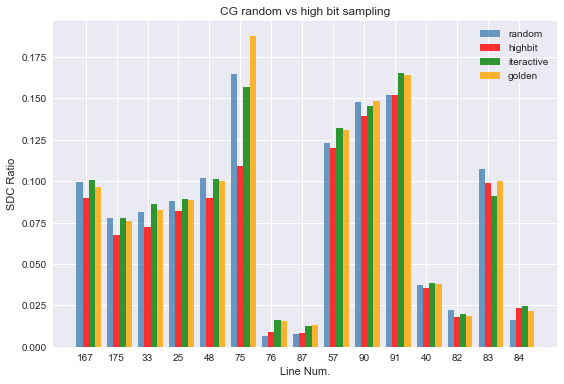

In [5]:
n_groups = len(random_expected_sdc)
#create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.2
opacity = 0.8

#random
rects1 = plt.bar(index, random_expected_sdc, bar_width, alpha=opacity, color='steelblue', label='random')

#highbit
rects2 = plt.bar(index + bar_width, highbit_expected_sdc, bar_width, alpha=opacity, color='red', label='highbit')

#iteractive
rects3 = plt.bar(index + 2 * bar_width, iteractive_expected_sdc, bar_width, alpha=opacity, color='green', label='iteractive')

#golden
rects4 = plt.bar(index + 3 * bar_width, golden_sdc, bar_width, alpha=opacity, color='orange', label='golden')

plt.xlabel('Line Num.')
plt.ylabel('SDC Ratio')
plt.title('CG random vs high bit sampling')
plt.xticks(index + bar_width,cg_df.Line.unique())
plt.legend()

plt.tight_layout()
plt.show()

# SDC Ratio Standard Deviation

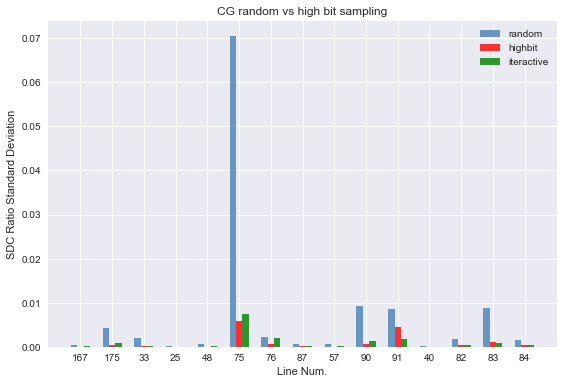

In [6]:
n_groups = len(random_expected_sdc)
#create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.2
opacity = 0.8

#random
rects1 = plt.bar(index, random_var_sdc, bar_width, alpha=opacity, color='steelblue', label='random')

#highbit
rects2 = plt.bar(index + bar_width, highbit_var_sdc, bar_width, alpha=opacity, color='red', label='highbit')

#iteractive
rects3 = plt.bar(index + 2 * bar_width, iteractive_var_sdc, bar_width, alpha=opacity, color='green', label='iteractive')

#golden
#rects4 = plt.bar(index + 3 * bar_width, golden_sdc, bar_width, alpha=opacity, color='orange', label='golden')
#plt.yscale('log', nonposy='clip')
plt.xlabel('Line Num.')
plt.ylabel('SDC Ratio Standard Deviation')
plt.title('CG random vs high bit sampling')
plt.xticks(index + bar_width,cg_df.Line.unique())
plt.legend()

plt.tight_layout()
plt.show()

# SDC Impact

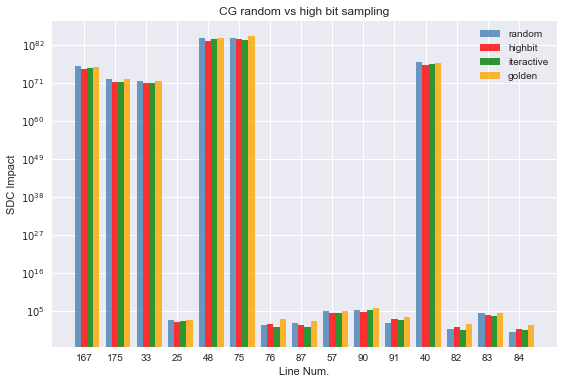

In [7]:
n_groups = len(random_expected_sdc)
#create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.2
opacity = 0.8

#random
rects1 = plt.bar(index, random_expected_impact, bar_width, alpha=opacity, color='steelblue', label='random')

#highbit
rects2 = plt.bar(index + bar_width, highbit_expected_impact, bar_width, alpha=opacity, color='red', label='highbit')

#iteractive
rects2 = plt.bar(index + 2 * bar_width, iteractive_expected_impact, bar_width, alpha=opacity, color='green', label='iteractive')

#golden
rects3 = plt.bar(index + 3 * bar_width, golden_impact, bar_width, alpha=opacity, color='orange', label='golden')

plt.yscale('log', nonposy='clip')
plt.xlabel('Line Num.')
plt.ylabel('SDC Impact')
plt.title('CG random vs high bit sampling')
plt.xticks(index + bar_width,cg_df.Line.unique())
plt.legend()

plt.tight_layout()
plt.show()

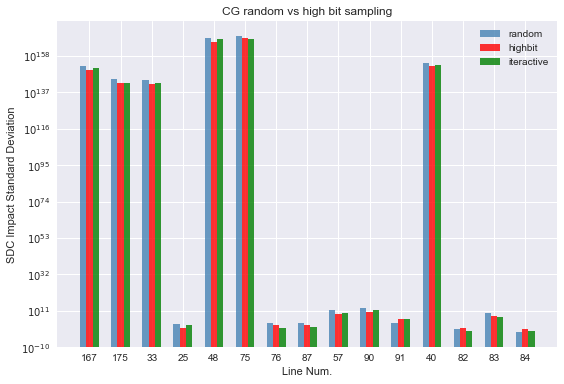

In [8]:
n_groups = len(random_expected_sdc)
#create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.2
opacity = 0.8

#random
rects1 = plt.bar(index, random_var_impact, bar_width, alpha=opacity, color='steelblue', label='random')

#highbit
rects2 = plt.bar(index + bar_width, highbit_var_impact, bar_width, alpha=opacity, color='red', label='highbit')

#iteractive
rects2 = plt.bar(index + 2 * bar_width, iteractive_var_impact, bar_width, alpha=opacity, color='green', label='iteractive')

#golden
#rects3 = plt.bar(index + 3 * bar_width, golden_impact, bar_width, alpha=opacity, color='orange', label='golden')

plt.yscale('log', nonposy='clip')
plt.xlabel('Line Num.')
plt.ylabel('SDC Impact Standard Deviation')
plt.title('CG random vs high bit sampling')
plt.xticks(index + bar_width,cg_df.Line.unique())
plt.legend()

plt.tight_layout()
plt.show()